# STEP 1A: Load and merge files
1️. Enrolment data (3 files)

In [46]:
import pandas as pd

enrolment_files = [
    "api_data_aadhar_enrolment_0_500000.csv",
    "api_data_aadhar_enrolment_500000_1000000.csv",
    "api_data_aadhar_enrolment_1000000_1006029.csv"
]

enrolment_df = pd.concat(
    [pd.read_csv(f) for f in enrolment_files],
    ignore_index=True
)

print(enrolment_df.shape)
enrolment_df.head()


(1006029, 7)


,date,state,district,pincode,age_0_5,age_5_17,age_18_greater
0,02-03-2025,Meghalaya,East Khasi Hills,793121,11,61,37
1,09-03-2025,Karnataka,Bengaluru Urban,560043,14,33,39
2,09-03-2025,Uttar Pradesh,Kanpur Nagar,208001,29,82,12
3,09-03-2025,Uttar Pradesh,Aligarh,202133,62,29,15
4,09-03-2025,Karnataka,Bengaluru Urban,560016,14,16,21


2. Demographic update data (5 files)

In [47]:
demographic_files = [
    "api_data_aadhar_demographic_0_500000.csv",
    "api_data_aadhar_demographic_500000_1000000.csv",
    "api_data_aadhar_demographic_1000000_1500000.csv",
    "api_data_aadhar_demographic_1500000_2000000.csv",
    "api_data_aadhar_demographic_2000000_2071700.csv"
]

demographic_df = pd.concat(
    [pd.read_csv(f) for f in demographic_files],
    ignore_index=True
)

print(demographic_df.shape)
demographic_df.head()


(2071700, 6)


,date,state,district,pincode,demo_age_5_17,demo_age_17_
0,01-03-2025,Uttar Pradesh,Gorakhpur,273213,49,529
1,01-03-2025,Andhra Pradesh,Chittoor,517132,22,375
2,01-03-2025,Gujarat,Rajkot,360006,65,765
3,01-03-2025,Andhra Pradesh,Srikakulam,532484,24,314
4,01-03-2025,Rajasthan,Udaipur,313801,45,785


3️. Biometric update data (4 files)

In [48]:
biometric_files = [
    "api_data_aadhar_biometric_0_500000.csv",
    "api_data_aadhar_biometric_500000_1000000.csv",
    "api_data_aadhar_biometric_1000000_1500000.csv",
    "api_data_aadhar_biometric_1500000_1861108.csv"
]

biometric_df = pd.concat(
    [pd.read_csv(f) for f in biometric_files],
    ignore_index=True
)

print(biometric_df.shape)
biometric_df.head()


(1861108, 6)


,date,state,district,pincode,bio_age_5_17,bio_age_17_
0,01-03-2025,Haryana,Mahendragarh,123029,280,577
1,01-03-2025,Bihar,Madhepura,852121,144,369
2,01-03-2025,Jammu and Kashmir,Punch,185101,643,1091
3,01-03-2025,Bihar,Bhojpur,802158,256,980
4,01-03-2025,Tamil Nadu,Madurai,625514,271,815


STEP 1B: Immediate sanity checks

In [49]:
for name, df in {
    "Enrolment": enrolment_df,
    "Demographic": demographic_df,
    "Biometric": biometric_df
}.items():
    print(f"\n{name}")
    print(df.isna().sum().head())
    print(df.dtypes.head())



Enrolment
date        0
state       0
district    0
pincode     0
age_0_5     0
dtype: int64
date        object
state       object
district    object
pincode      int64
age_0_5      int64
dtype: object

Demographic
date             0
state            0
district         0
pincode          0
demo_age_5_17    0
dtype: int64
date             object
state            object
district         object
pincode           int64
demo_age_5_17     int64
dtype: object

Biometric
date            0
state           0
district        0
pincode         0
bio_age_5_17    0
dtype: int64
date            object
state           object
district        object
pincode          int64
bio_age_5_17     int64
dtype: object


Make  confermation Column names of each DataFrame

In [50]:
(df.columns.tolist())

['date', 'state', 'district', 'pincode', 'bio_age_5_17', 'bio_age_17_']

STEP 2A: Standardise DATE → year_month

In [51]:
def standardize_date(df):
    df['date'] = pd.to_datetime(df['date'], dayfirst=True, errors='coerce')
    df['year_month'] = df['date'].dt.to_period('M').astype(str)
    return df



In [52]:
enrolment_df = standardize_date(enrolment_df)
demographic_df = standardize_date(demographic_df)
biometric_df = standardize_date(biometric_df)


STEP 2B: Clean state and district

In [53]:
def standardize_location(df):
    df['state'] = (
        df['state']
        .str.strip()
        .str.upper()
    )
    
    df['district'] = (
        df['district']
        .str.strip()
        .str.upper()
    )
    
    return df


In [54]:
enrolment_df = standardize_location(enrolment_df)
demographic_df = standardize_location(demographic_df)
biometric_df = standardize_location(biometric_df)


# STEP 2C: Aggregate at Common Granularity
1️. Enrolment aggregation

In [55]:
enrolment_agg = (
    enrolment_df
    .groupby(['state', 'district', 'year_month'], as_index=False)
    .sum(numeric_only=True)
)


2️. Demographic aggregation

In [56]:
demographic_agg = (
    demographic_df
    .groupby(['state', 'district', 'year_month'], as_index=False)
    .sum(numeric_only=True)
)


3️. Biometric aggregation

In [57]:
biometric_agg = (
    biometric_df
    .groupby(['state', 'district', 'year_month'], as_index=False)
    .sum(numeric_only=True)
)


# STEP 2D: Merge the Datasets

Merge enrolment + demographic

In [58]:
merged_df = enrolment_agg.merge(
    demographic_agg,
    on=['state', 'district', 'year_month'],
    how='left'
)


Merge biometric

In [59]:
merged_df = merged_df.merge(
    biometric_agg,
    on=['state', 'district', 'year_month'],
    how='left'
)


# STEP 2E: Final sanity check

In [60]:
print("Final merged shape:", merged_df.shape)
merged_df.head()


Final merged shape: (5004, 13)


,state,district,year_month,pincode_x,age_0_5,age_5_17,age_18_greater,pincode_y,demo_age_5_17,demo_age_17_,pincode,bio_age_5_17,bio_age_17_
0,100000,100000,2025-09,800000,0,0,12,NaN,NaN,NaN,NaN,NaN,NaN
1,100000,100000,2025-10,100000,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN
2,100000,100000,2025-11,400000,0,0,11,NaN,NaN,NaN,NaN,NaN,NaN
3,100000,100000,2025-12,900000,0,0,194,200000.0,0.0,2.0,NaN,NaN,NaN
4,ANDAMAN & NICOBAR ISLANDS,ANDAMANS,2025-09,18602703,23,4,0,49111191.0,3.0,159.0,66226052.0,76.0,241.0


In [61]:
merged_df.columns
merged_df.isna().sum().sort_values(ascending=False).head(10)


demo_age_5_17    685
pincode_y        685
demo_age_17_     685
pincode          103
bio_age_5_17     103
bio_age_17_      103
age_0_5            0
year_month         0
district           0
state              0
dtype: int64

# STEP 3A: Create Core Derived Indicators
1️. Total enrolments (base denominator)

In [62]:
enrolment_cols = ['age_0_5', 'age_5_17', 'age_18_greater']

merged_df['total_enrolments'] = merged_df[enrolment_cols].sum(axis=1)


2️. Total biometric updates

In [63]:
biometric_cols = [col for col in merged_df.columns if col.startswith('bio_')]

merged_df['total_biometric_updates'] = merged_df[biometric_cols].sum(axis=1)


3️. Total demographic updates

In [64]:
demographic_cols = [col for col in merged_df.columns if col.startswith('demo_')]

merged_df['total_demographic_updates'] = merged_df[demographic_cols].sum(axis=1)


# STEP 3B: Biometric Churn Index (BCI)

In [65]:
merged_df['biometric_churn_index'] = (
    merged_df['total_biometric_updates'] /
    merged_df['total_enrolments'].replace(0, pd.NA)
)


# STEP 3C: Demographic Drift Ratio (DDR)

In [66]:
merged_df['demographic_drift_ratio'] = (
    merged_df['total_demographic_updates'] /
    merged_df['total_enrolments'].replace(0, pd.NA)
)


Interpretation:

High DDR → migration, correction-heavy enrolment, service churn

Low DDR → stable population records

# STEP 3D: Stress Signal Index (Composite)

In [67]:
merged_df['system_stress_index'] = (
    0.6 * merged_df['biometric_churn_index'] +
    0.4 * merged_df['demographic_drift_ratio']
)


# STEP 3E: Anomaly Detection

Z-score based anomaly detection

In [68]:
from scipy.stats import zscore

merged_df['stress_zscore'] = (
    merged_df
    .groupby('state')['system_stress_index']
    .transform(lambda x: zscore(x, nan_policy='omit'))
)


Flag anomalies

In [69]:
merged_df['stress_anomaly'] = merged_df['stress_zscore'].abs() > 2


# STEP 3F: Quick Validation

In [70]:
merged_df[
    ['biometric_churn_index',
     'demographic_drift_ratio',
     'system_stress_index']
].describe()


merged_df['stress_anomaly'].value_counts()



stress_anomaly
False    4853
True      151
Name: count, dtype: int64

In [71]:
merged_df[
    ['state', 'district', 'year_month',
     'system_stress_index', 'stress_anomaly']
].sort_values('system_stress_index', ascending=False).head(10)


,state,district,year_month,system_stress_index,stress_anomaly
2769,MAHARASHTRA,THANE,2025-03,1300.472340,True
1105,DELHI,NORTH WEST DELHI,2025-03,910.360000,True
2717,MAHARASHTRA,PUNE,2025-04,627.527536,True
4412,UTTAR PRADESH,GORAKHPUR,2025-03,539.980000,True
723,BIHAR,MUZAFFARPUR,2025-03,513.470270,True
750,BIHAR,PATNA,2025-03,459.565000,True
614,BIHAR,BHAGALPUR,2025-03,452.107042,True
4322,UTTAR PRADESH,BULANDSHAHR,2025-03,442.413115,True
3400,PUNJAB,AMRITSAR,2025-03,415.546939,True
1738,JHARKHAND,DEOGHAR,2025-03,313.614545,True


# STEP 4.1 — Line Plot
System Stress Index over Time (Top 5 States)

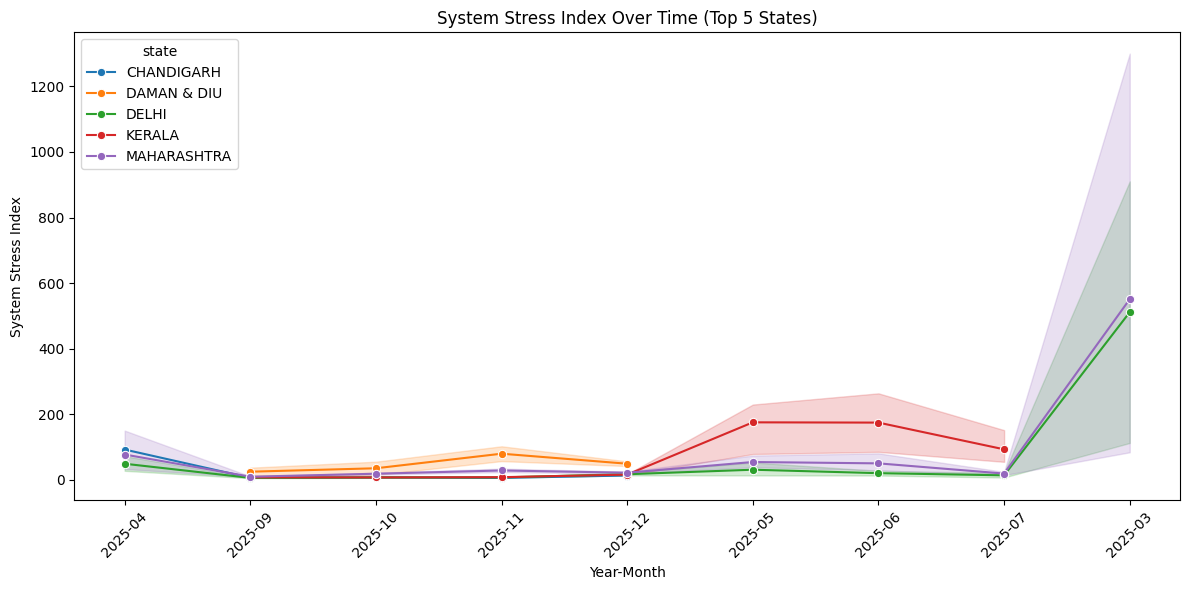

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select top 5 states by average stress
top_states = (
    merged_df
    .groupby('state')['system_stress_index']
    .mean()
    .sort_values(ascending=False)
    .head(5)
    .index
)

plt.figure(figsize=(12, 6))

sns.lineplot(
    data=merged_df[merged_df['state'].isin(top_states)],
    x='year_month',
    y='system_stress_index',
    hue='state',
    marker='o'
)

plt.title("System Stress Index Over Time (Top 5 States)")
plt.xlabel("Year-Month")
plt.ylabel("System Stress Index")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# STEP 4.2 — Heatmap
State × Month → Biometric Churn Index

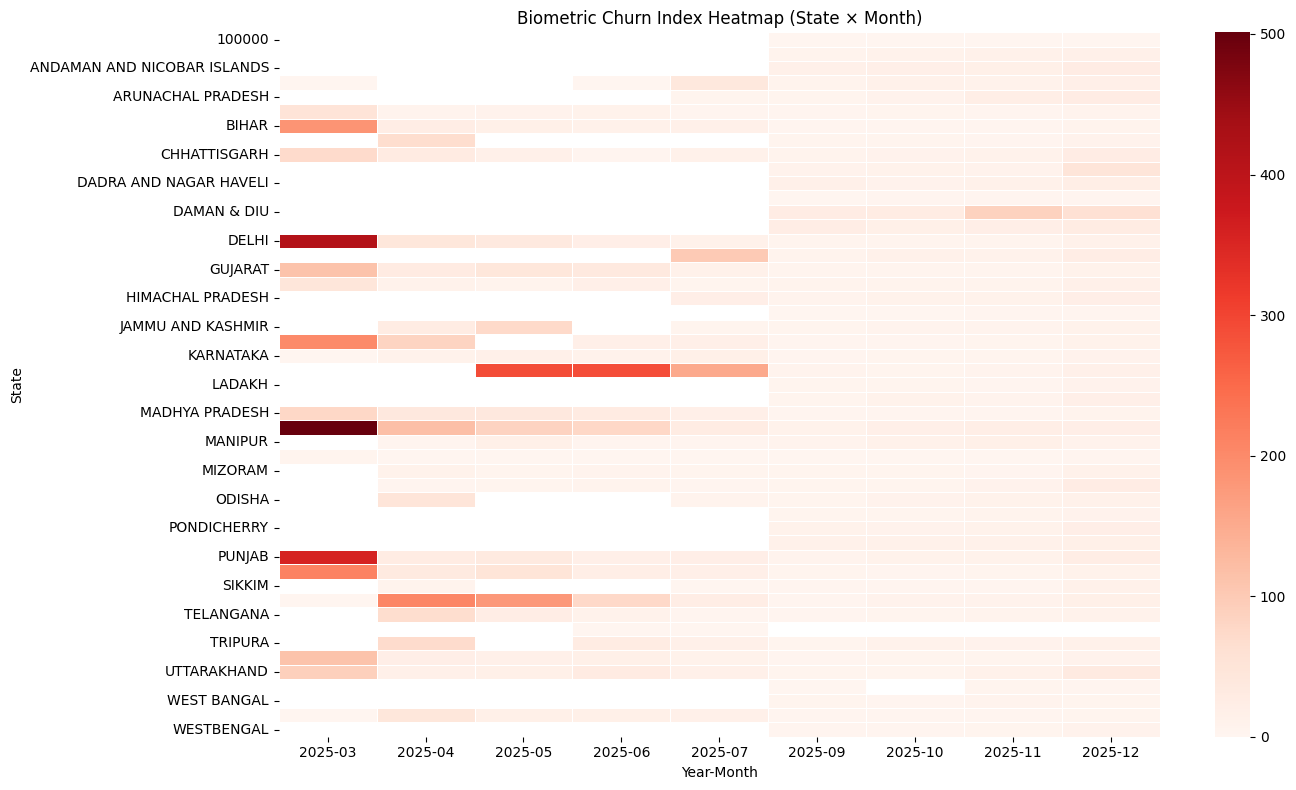

In [73]:
heatmap_data = (
    merged_df
    .groupby(['state', 'year_month'])['biometric_churn_index']
    .mean()
    .reset_index()
    .pivot(index='state', columns='year_month', values='biometric_churn_index')
)

plt.figure(figsize=(14, 8))

sns.heatmap(
    heatmap_data,
    cmap='Reds',
    linewidths=0.5
)

plt.title("Biometric Churn Index Heatmap (State × Month)")
plt.xlabel("Year-Month")
plt.ylabel("State")
plt.tight_layout()
plt.show()


# STEP 4.3 — Scatter Plot (Bivariate)
Total Enrolments vs Biometric Churn Index

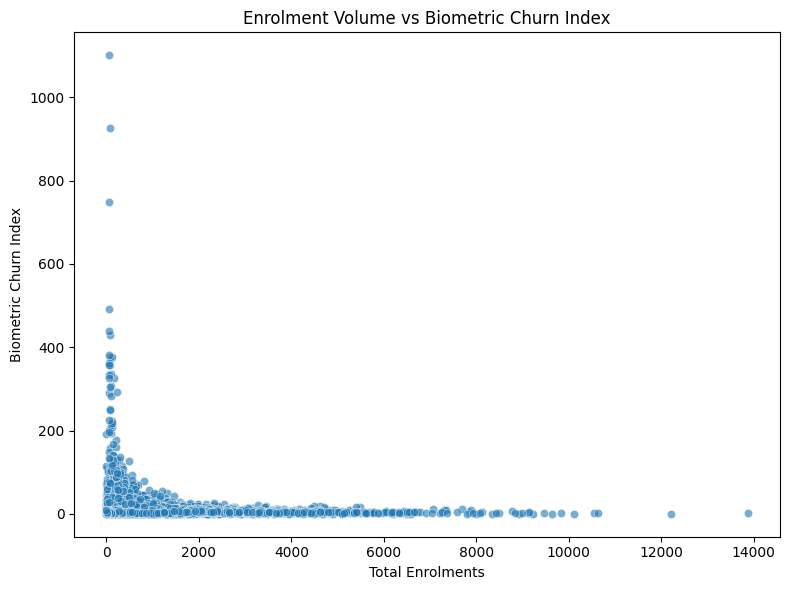

In [74]:
plt.figure(figsize=(8, 6))

sns.scatterplot(
    data=merged_df,
    x='total_enrolments',
    y='biometric_churn_index',
    alpha=0.6
)

plt.title("Enrolment Volume vs Biometric Churn Index")
plt.xlabel("Total Enrolments")
plt.ylabel("Biometric Churn Index")
plt.tight_layout()
plt.show()


# STEP 4.4 — FacetGrid (Tri-variate)
Time × State → Demographic Drift Ratio

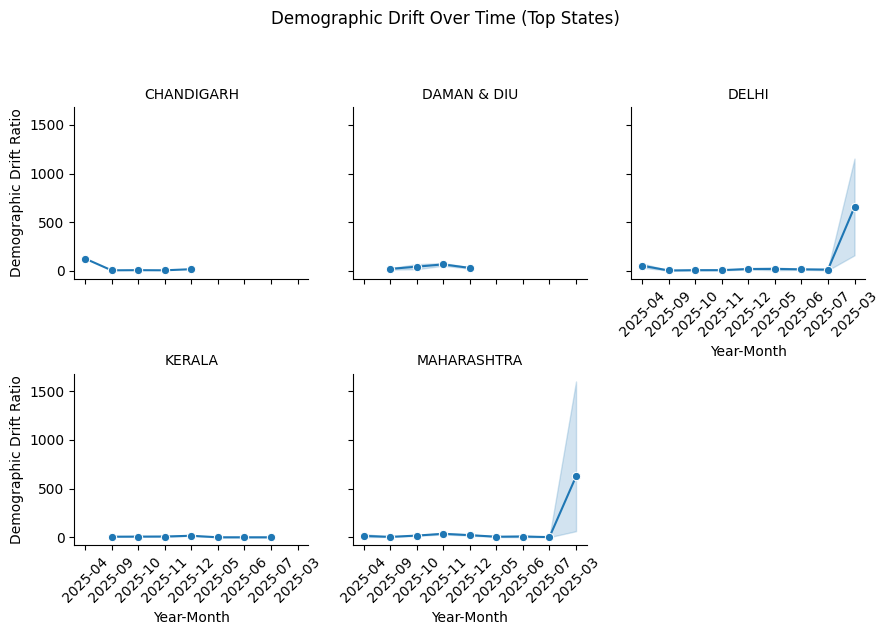

In [75]:
g = sns.FacetGrid(
    merged_df[merged_df['state'].isin(top_states)],
    col='state',
    col_wrap=3,
    height=3,
    sharey=True
)

g.map_dataframe(
    sns.lineplot,
    x='year_month',
    y='demographic_drift_ratio',
    marker='o'
)

g.set_titles("{col_name}")
g.set_axis_labels("Year-Month", "Demographic Drift Ratio")
g.fig.suptitle("Demographic Drift Over Time (Top States)", y=1.05)

for ax in g.axes.flatten():
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


# STEP 4.5 — Boxplot
Stress Index Distribution by State

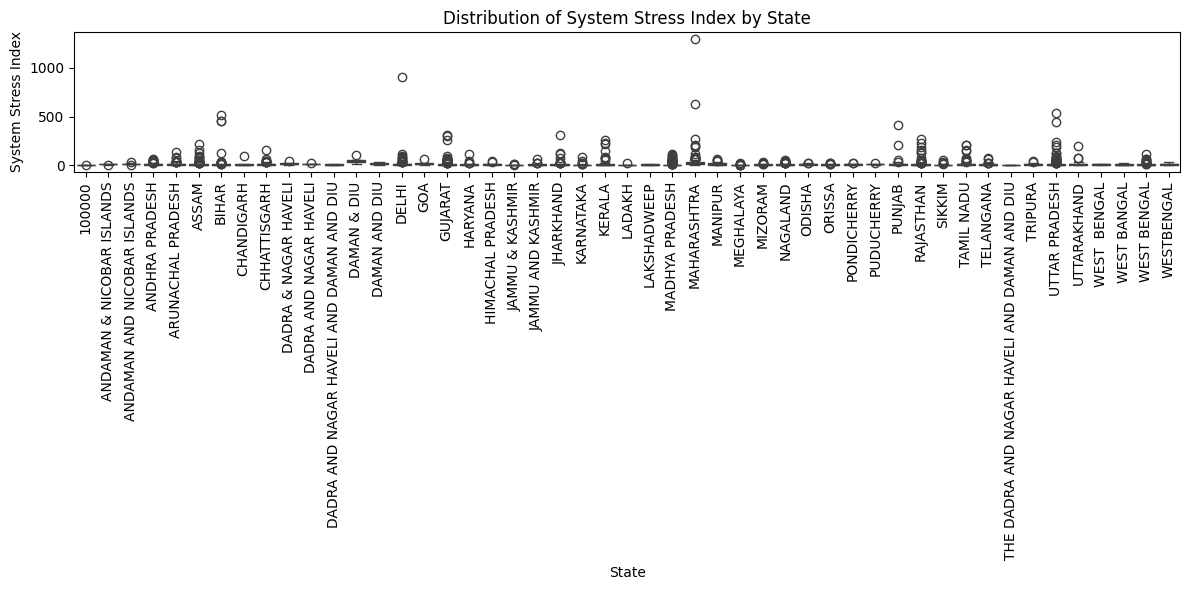

In [76]:
plt.figure(figsize=(12, 6))

sns.boxplot(
    data=merged_df,
    x='state',
    y='system_stress_index'
)

plt.xticks(rotation=90)
plt.title("Distribution of System Stress Index by State")
plt.xlabel("State")
plt.ylabel("System Stress Index")
plt.tight_layout()
plt.show()


# STEP 4.6 — Anomaly Table

In [77]:
top_anomalies = (
    merged_df[merged_df['stress_anomaly']]
    .sort_values('system_stress_index', ascending=False)
    [['state', 'district', 'year_month', 'system_stress_index']]
    .head(10)
)

top_anomalies


,state,district,year_month,system_stress_index
2769,MAHARASHTRA,THANE,2025-03,1300.472340
1105,DELHI,NORTH WEST DELHI,2025-03,910.360000
2717,MAHARASHTRA,PUNE,2025-04,627.527536
4412,UTTAR PRADESH,GORAKHPUR,2025-03,539.980000
723,BIHAR,MUZAFFARPUR,2025-03,513.470270
750,BIHAR,PATNA,2025-03,459.565000
614,BIHAR,BHAGALPUR,2025-03,452.107042
4322,UTTAR PRADESH,BULANDSHAHR,2025-03,442.413115
3400,PUNJAB,AMRITSAR,2025-03,415.546939
1738,JHARKHAND,DEOGHAR,2025-03,313.614545
